SEEFOOD
===

what would you say if i told you there is an app on the market that tell you if you have a hotdog or not a hotdog

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import tensorflow as tf
from skimage import exposure
from tensorflow.contrib.layers import flatten
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.contrib.layers import flatten

from tensorflow import keras
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
import cv2
import glob
from keras.layers.convolutional import Conv2D

%matplotlib inline

data collection
---

this cell collects the images from imagenet

In [15]:
'''
import urllib
import urllib.request
import cv2
import os
from multiprocessing.dummy import Pool as ThreadPool 
import itertools

pic_num = 1

# downloads & saves images, maybe
def store_raw_images(paths, links):
    global pic_num
    for link, path in zip(links, paths):
        if not os.path.exists(path):
            os.makedirs(path)
        image_urls = str(urllib.request.urlopen(link).read())
        
        pool = ThreadPool(32)
        pool.starmap(loadImage, zip(itertools.repeat(path),image_urls.split('\\n'),itertools.count(pic_num))) 
        pool.close() 
        pool.join()
                    
def loadImage(path,link, counter):
    global pic_num
    if pic_num < counter:
        pic_num = counter+1;
    try:                
        urllib.request.urlretrieve(link, path+"/"+str(counter)+".jpg")
        img = cv2.imread(path+"/"+str(counter)+".jpg")             
        if img is not None:
            cv2.imwrite(path+"/"+str(counter)+".jpg",img)
            print(counter)

    except Exception as e:
        print(str(e))
        
# drives code                        
def main():
    links = [
            'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n07690019', \
            'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n13104059', \
            'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n07865105' ]
    paths = ['frankfurters', 'trees', 'chili dogs']
    
    
    
    store_raw_images(paths, links)
    
if __name__ == "__main__":
    main()
'''

'\nimport urllib\nimport urllib.request\nimport cv2\nimport os\nfrom multiprocessing.dummy import Pool as ThreadPool \nimport itertools\n\npic_num = 1\n\n# downloads & saves images, maybe\ndef store_raw_images(paths, links):\n    global pic_num\n    for link, path in zip(links, paths):\n        if not os.path.exists(path):\n            os.makedirs(path)\n        image_urls = str(urllib.request.urlopen(link).read())\n        \n        pool = ThreadPool(32)\n        pool.starmap(loadImage, zip(itertools.repeat(path),image_urls.split(\'\\n\'),itertools.count(pic_num))) \n        pool.close() \n        pool.join()\n                    \ndef loadImage(path,link, counter):\n    global pic_num\n    if pic_num < counter:\n        pic_num = counter+1;\n    try:                \n        urllib.request.urlretrieve(link, path+"/"+str(counter)+".jpg")\n        img = cv2.imread(path+"/"+str(counter)+".jpg")             \n        if img is not None:\n            cv2.imwrite(path+"/"+str(counter)+".jp

data cleaning
---

this cell is where the code that cleans out invalid images lives.
run the cell to clean out invalid images

In [16]:
'''
# this cleans out invalid files. or, it was supposed to
def removeInvalid(dirPaths):
    for dirPath in dirPaths:
        for img in os.listdir(dirPath):
            for invalid in os.listdir('invalid'):
                try:
                    current_image_path = str(dirPath)+'/'+str(img)
                    invalid = cv2.imread('invalid/'+str(invalid))
                    question = cv2.imread(current_image_path)
                    if invalid.shape == question.shape and not(np.bitwise_xor(invalid,question).any()):
                        os.remove(current_image_path)
                        break

                except Exception as e:
                    print(str(e))
print("invalid images apparently removed")
'''

'\n# this cleans out invalid files. or, it was supposed to\ndef removeInvalid(dirPaths):\n    for dirPath in dirPaths:\n        for img in os.listdir(dirPath):\n            for invalid in os.listdir(\'invalid\'):\n                try:\n                    current_image_path = str(dirPath)+\'/\'+str(img)\n                    invalid = cv2.imread(\'invalid/\'+str(invalid))\n                    question = cv2.imread(current_image_path)\n                    if invalid.shape == question.shape and not(np.bitwise_xor(invalid,question).any()):\n                        os.remove(current_image_path)\n                        break\n\n                except Exception as e:\n                    print(str(e))\nprint("invalid images apparently removed")\n'

preprocessing, normalization, and augmentation
---
take a wild guess what this one does.
no seriously i barely know what it does.
(i think it's like, it resizes the images, and modifies them so we have more data? something like that)

In [17]:
# add rotation and blur/load those good good functions
def rotateImage(img, angle):
    (rows, cols, ch) = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    return cv2.warpAffine(img, M, (cols, rows))

def loadBlurImg(path, imgSize):
    img = cv2.imread(path)
    angle = np.random.randint(0, 360)
    img = rotateImage(img, angle)
    img = cv2.blur(img, (5,5))
    img = cv2.resize(img, imgSize)
    return img

def loadImgClass(classPath, classLabel, classSize, imgSize):
    x = []
    y = []
    
    for path in classPath:
        img = loadBlurImg(path, imgSize)
        x.append(img)
        y.append(classLabel)
        
        while len(x) < classSize:
            randIdx = np.random.randint(0, len(classPath))
            img = loadBlurImg(classPath[randIdx], imgSize)
            x.append(img)
            y.append(classLabel)
            
        return x, y
    
def loadData(img_size, classSize):
    hotdogs = glob.glob('./hotdog project/hotdog/**/*.jpg', recursive=True)
    notHotdogs = glob.glob('./hotdog project/not-hotdog/**/*.jpg', recursive=True)
    
    
    imgSize = (img_size, img_size)
    xHotdog, yHotdog = loadImgClass(hotdogs, 0, classSize, imgSize)
    xNotHotdog, yNotHotdog = loadImgClass(notHotdogs, 1, classSize, imgSize)
    print("there are ", len(xHotdog), " hotdog images")
    print("there are ", len(xNotHotdog), " not hotdog images")
    
    X = np.array(xHotdog + xNotHotdog)
    y = np.array(yHotdog + yNotHotdog)
    
    return X, y

#normalize: grayscale and histogram equalization. preprocessing happens here
def toGray(images):
     #rgb2gray converts RGB values to grayscale values by forming a weighted sum of the R, G, and B components:
     #0.2989 * R + 0.5870 * G + 0.1140 * B 
    # source: https://www.mathworks.com/help/matlab/ref/rgb2gray.html
    
    images = 0.2989*images[:,:,:,0] + 0.5870*images[:,:,:,1] + 0.1140*images[:,:,:,2]
    return images

def normalizeImages(images):
    #use histogram equalization to get a better range
    # source http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
    images = (images / 255.).astype(np.float32)
    
    for i in range(images.shape[0]):
        images[i] = exposure.equalize_hist(images[i])
        
    images = images.reshape(images.shape + (1,))
    return images

def preprocessData(images):
    grayImages = toGray(images)
    return normalizeImages(grayImages)

def normalizeImages2(images):
    for i in range(images.shape[0]):
        cv2.normalize(images[i],images[i], alpha = 0, beta = 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
    #if convert to grayscale use this after
    print("images has shape before", images.shape)
    images = images.reshape(images.shape + (1,))
    print("images has shape after", images.shape)
    return images

loading of the data
---

In [18]:
size = 128
classSize = 1780
print("loading data....")
scaled_X, y = loadData(size, classSize)
print("check")
scaled_X = preprocessData(scaled_X)
print(scaled_X)
print(y)

n_classes = len(np.unique(y))

from keras.utils.np_utils import to_categorical
y = to_categorical(y)

loading data....
there are  1780  hotdog images
there are  1780  not hotdog images
check
[[[[ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]
   ..., 
   [ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]]

  [[ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]
   ..., 
   [ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]]

  [[ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]
   ..., 
   [ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]]

  ..., 
  [[ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]
   ..., 
   [ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]]

  [[ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]
   ..., 
   [ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]]

  [[ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]
   ..., 
   [ 0.22821045]
   [ 0.22821045]
   [ 0.22821045]]]


 [[[ 0.06427002]
   [ 0.06427002]
   [ 0.06427002]
   ..., 
   [ 0.06427002]
   [ 0.06427002]
   [ 0.06427002]]

  [[ 0.06427002]
   [ 0.06427002]
   [ 0.06427002]
   ..., 
   [ 0.06427002]
   [ 0.06427002]
   [ 0.06427002]

train/test split
---

In [19]:
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print("number of classes = ", n_classes)
print("train shape X", X_train.shape)
print("train shape y", y_train.shape)

number of classes =  2
train shape X (2848, 128, 128, 1)
train shape y (2848, 2)


building the model
---

In [22]:
def karasModel2(inputShape):
    model = Sequential()
    model.add(Conv2D(16, 8, 8, subsample=(4, 4),border_mode='valid', input_shape=inputShape))
    model.add(ELU())
    model.add(Conv2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Conv2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(2))
    model.add(Activation('softmax'))
    return model

training
---

In [23]:
# TODO: implement the training loop
inputShape = (size, size, 1)
model = karasModel2(inputShape)

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_train, y_train, epochs=15, validation_split=0.1)

# testing

print("X_test length:",len(X_test))
print("Y_test length:",len(y_test))

metrics = model.evaluate(X_test, y_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    #print('{}: {}'.format(metric_name, metric_value))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), input_shape=(128, 128,..., strides=(4, 4), padding="valid")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(2, 2), padding="same")`
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), strides=(2, 2), padding="same")`
  import sys


Train on 2563 samples, validate on 285 samples
Epoch 1/15
2563/2563 [==============================] - 9s 3ms/step - loss: 0.7620 - acc: 0.5045 - val_loss: 0.7103 - val_acc: 0.5053
Epoch 2/15
2563/2563 [==============================] - 8s 3ms/step - loss: 0.6675 - acc: 0.5895 - val_loss: 0.7060 - val_acc: 0.5263
Epoch 3/15
2563/2563 [==============================] - 8s 3ms/step - loss: 0.6274 - acc: 0.6481 - val_loss: 0.7550 - val_acc: 0.5719
Epoch 4/15
2563/2563 [==============================] - 8s 3ms/step - loss: 0.6014 - acc: 0.6676 - val_loss: 0.7467 - val_acc: 0.5404
Epoch 5/15
2563/2563 [==============================] - 8s 3ms/step - loss: 0.5614 - acc: 0.7085 - val_loss: 0.8295 - val_acc: 0.5088
Epoch 6/15
2563/2563 [==============================] - 8s 3ms/step - loss: 0.4957 - acc: 0.7550 - val_loss: 0.9660 - val_acc: 0.5298
Epoch 7/15
2563/2563 [==============================] - 8s 3ms/step - loss: 0.4660 - acc: 0.7733 - val_loss: 1.0415 - val_acc: 0.5158
Epoch 8/15
2563

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), input_shape=(128, 128,..., strides=(4, 4), padding="valid")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(2, 2), padding="same")`
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), strides=(2, 2), padding="same")`
  import sys


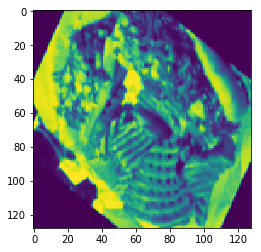

Prediction: not hotdog


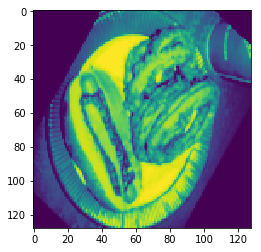

Prediction: not hotdog


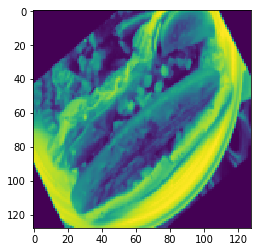

Prediction: not hotdog


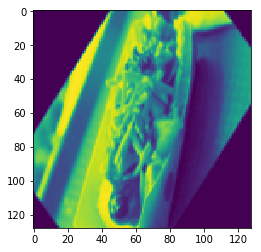

Prediction: not hotdog


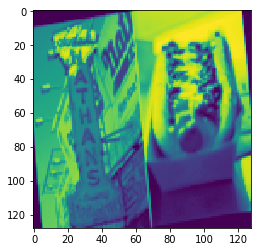

Prediction: not hotdog


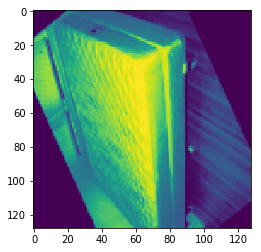

Prediction: not hotdog


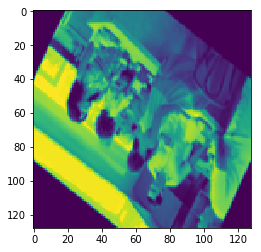

Prediction: hotdog


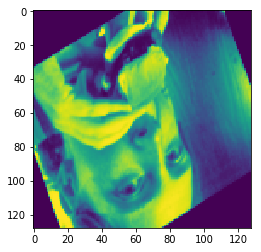

Prediction: not hotdog


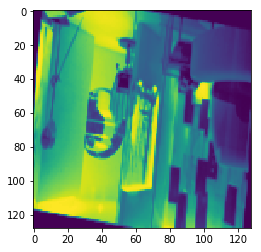

Prediction: not hotdog


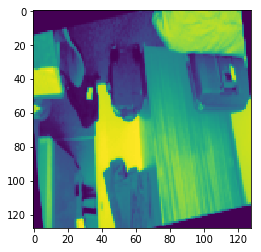

Prediction: not hotdog


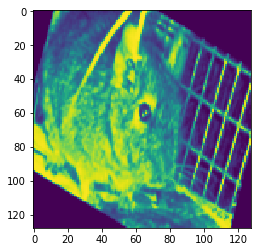

Prediction: not hotdog


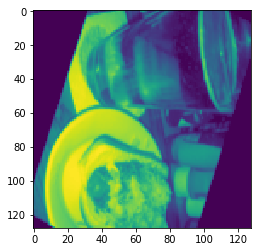

Prediction: not hotdog


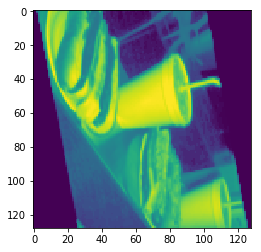

Prediction: not hotdog


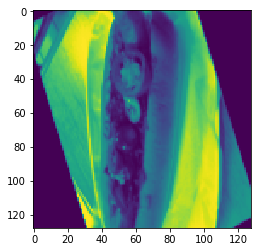

Prediction: not hotdog


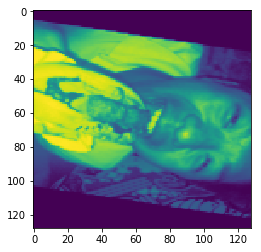

Prediction: not hotdog


In [25]:
# get random images and guess for them
model = karasModel2(inputShape)
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

for i in range(0,15):
    img_data = X_test[i]
    img_backup = img_data
    img_backup_sliced = img_backup[:, :, 0]

    
    img_data = np.expand_dims(img_data, axis=0)
    model_out = model.predict(img_data)
    if np.argmax(model_out) == 1: 
        str_label = 'hotdog'
    else: 
        str_label = 'not hotdog'
    plt.imshow(img_backup_sliced)
    plt.show()

    print("Prediction:",str_label)

In [ ]:
model.save('model.h5')